In [10]:
# import FinanceDataReader as fdr
# import numpy as np

# etfkr = fdr.StockListing("ETF/KR")
# krx = fdr.StockListing("KRX")

# def search_code(name):
#     code = krx[krx['Name'] == name]['Code']
#     # 결과가 있으면 해당 종목 코드를 반환하고, 없으면 None 반환
#     if not code.empty:
#         return code.values[0]

#     code = etfkr[etfkr['Name'].str.strip() == name]['Symbol']
#     # display(code)    
#     if not code.empty:
#         return code.values[0]
        
#     return np.nan

# 종목명 = 'RISE 미국30년국채엔화노출(합성 H)'
# 코드 = search_code(종목명)
# display(코드)
# 'RISE 미국채30년엔화노출(합성 H)'
# test = etfkr[etfkr['Name'].str.contains('RISE')]
# display(test['Name'].values)
# test['Name'].values == 'RISE 미국30년국채엔화노출(합성 H)'


In [11]:
import pandas as pd
import os

# CSV 파일을 줄 단위로 읽기

def read_csv(file_path):
    file_name = os.path.basename(file_path)
    file_prefix = file_name.split('-')[0] 

    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # 홀수 줄과 짝수 줄을 결합하여 하나의 줄로 만듬
    merged_lines = []
    for i in range(0, len(lines) - 1, 2):
        merged_line = lines[i].strip() + ',' + lines[i + 1].strip()  # 쉼표를 이용해 두 줄 결합
        merged_lines.append(merged_line)

    # 결합된 데이터를 DataFrame으로 바로 변환
    from io import StringIO

    # 결합된 라인들을 하나의 문자열로 변환
    merged_data = "\n".join(merged_lines)

    # pandas에서 이를 읽어들이기 위해 StringIO 객체로 변환
    df = pd.read_csv(StringIO(merged_data))
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    
    if '거래일자' in df.columns:
        df = df.rename(columns={'거래일자': '거래일'})

    if '거래상세유형' in df.columns:
        df = df.rename(columns={'거래상세유형': '거래종류'})
        
    if '종목명' in df.columns:
        df = df.rename(columns={'종목명': '상품명'})
        
    df['계좌'] = file_prefix[:8] + '-' + file_prefix[8:]
    df['코드'] = 0
    df['거래금'] = df['거래금액']
    df['정산금'] = df['정산금액']
    df['수량'] = df['거래수량']
    df['종류'] = df['거래종류']
        
    df['종류'] = df['종류'].str.replace('[', '', regex=False).str.replace(']', '', regex=False)
    df['종류'] = df['종류'].str.replace('Smart+', '', regex=False)
       
    df['거래금'] = df['거래금'].astype(str).str.replace(',', '')
    df['거래금'] = pd.to_numeric(df['거래금'], errors='coerce')
    df['정산금'] = df['정산금'].astype(str).str.replace(',', '')
    df['정산금'] = pd.to_numeric(df['정산금'], errors='coerce')
    df['수량'] = df['수량'].astype(str).str.replace(',', '')
    df['수량'] = pd.to_numeric(df['수량'], errors='coerce')
    
    df.loc[df['수량'] == 0, '수량'] = df['거래금']
    df['단가'] = df['거래금'] / df['수량']
    df['단가'] = pd.to_numeric(df['단가'], errors='coerce')
    
    # '상품명' 컬럼에서 NaN 값을 '현금성자산'으로 변경
    df.loc[df['상품명'].isna(), '상품명'] = '현금성자산'
    df = df[['거래일', '종류', '거래금', '수수료', '세금', '정산금', '단가', '수량', '계좌', '상품명', '코드']]
    
    df = df[~df['종류'].str.contains('전환')]
    
    df['거래일'] = pd.to_datetime(df['거래일'], format='%Y.%m.%d')
    df.set_index('거래일', inplace=True)
    df = df.sort_index()
    
    return df

# 결과 출력
df1 = read_csv('6401254829-20241008.csv')
df2 = read_csv('6401254822-20241008.csv')
df3 = read_csv('6398149401-20240907.csv')
df4 = read_csv('6426731622-20241008.csv')
df5 = read_csv('6404327801-20241008.csv')

display(df1)
display(df2)
display(df3)
display(df4)
display(df5)

df = pd.concat([df1, df2, df3, df4, df5])
df.sort_index(inplace=True)

# display(df)


,종류,거래금,수수료,세금,정산금,단가,수량,계좌,상품명,코드
거래일,,,,,,,,,,
2023-12-22,기본부담금,1000000,0,0,1000000,1.0,1000000,64012548-29,현금성자산,0
2023-12-26,정기대기이자입금,382,0,0,382,1.0,382,64012548-29,현금성자산,0
2023-12-27,거래소주식매수,114685,0,0,114685,114685.0,1,64012548-29,KOSEF 국고채10년,0
2023-12-27,기본부담금,2000000,0,0,2000000,1.0,2000000,64012548-29,현금성자산,0
2023-12-27,정기대기이자입금,96,0,0,96,1.0,96,64012548-29,현금성자산,0
...,...,...,...,...,...,...,...,...,...,...
2024-10-04,거래소주식매도,15905,0,0,15905,15905.0,1,64012548-29,ACE KRX금현물,0
2024-10-04,거래소주식매수,12735,0,0,12735,12735.0,1,64012548-29,KODEX 200미국채혼합,0
2024-10-04,정기대기이자입금,13,0,0,13,1.0,13,64012548-29,현금성자산,0


,종류,거래금,수수료,세금,정산금,단가,수량,계좌,상품명,코드
거래일,,,,,,,,,,
2023-12-22,당사이체입금,5000000,0,0,5000000,1.0,5000000,64012548-22,현금성자산,0
2023-12-27,당사이체입금,1000000,0,0,1000000,1.0,1000000,64012548-22,현금성자산,0
2024-01-02,거래소주식매수,5266000,221,0,5266221,105320.0,50,64012548-22,KODEX KOFR금리액티브(합성),0
2024-01-02,거래소주식매수,98950,4,0,98954,9895.0,10,64012548-22,KBSTAR 미국채30년엔화노출(합성 H),0
2024-01-03,거래소주식매수,100600,4,0,100604,10060.0,10,64012548-22,KBSTAR 미국채30년엔화노출(합성 H),0
...,...,...,...,...,...,...,...,...,...,...
2024-09-20,거래소주식매수,942000,39,0,942039,18840.0,50,64012548-22,ACE 미국S&P500,0
2024-09-25,거래소주식매도,1084000,45,0,1083955,10840.0,100,64012548-22,ACE 미국달러SOFR금리(합성),0
2024-10-02,거래소주식매수,655250,27,0,655277,13105.0,50,64012548-22,KODEX 미국S&P500에너지(합성),0


,종류,거래금,수수료,세금,정산금,단가,수량,계좌,상품명,코드
거래일,,,,,,,,,,
2023-12-27,타사이체입금,2000000,0,0,2000000,1.000000,2000000,63981494-01,현금성자산,0
2023-12-27,당사이체출금,2000000,0,0,2000000,1.000000,2000000,63981494-01,현금성자산,0
2023-12-27,타사이체입금,1000000,0,0,1000000,1.000000,1000000,63981494-01,현금성자산,0
2023-12-27,당사이체출금,1000000,0,0,1000000,1.000000,1000000,63981494-01,현금성자산,0
2024-04-26,타사이체입금,1000000,0,0,1000000,1.000000,1000000,63981494-01,현금성자산,0
2024-04-30,거래소주식매수,290750,12,0,290762,9691.666667,30,63981494-01,SOL 미국30년국채커버드콜(합성),0
2024-05-02,ETF분배금입금,2940,0,0,2940,1.000000,2940,63981494-01,신한 SOL 미국30년국채커버드콜증권상장지수투자신탁[채권-파생_,0
2024-05-03,거래소주식매도,291750,12,0,291738,9725.000000,30,63981494-01,SOL 미국30년국채커버드콜(합성),0
2024-05-08,타사이체출금,1003916,0,0,1003916,1.000000,1003916,63981494-01,현금성자산,0


,종류,거래금,수수료,세금,정산금,단가,수량,계좌,상품명,코드
거래일,,,,,,,,,,
2024-04-26,타사이체입금,47239473,0,0,47239473,1.0,47239473,64267316-22,현금성자산,0
2024-04-30,거래소주식매수,1769500,74,0,1769574,17695.0,100,64267316-22,ACE 미국S&P500,0
2024-04-30,거래소주식매수,749500,31,0,749531,14990.0,50,64267316-22,ACE KRX금현물,0
2024-04-30,거래소주식매수,24492960,"1,030",0,24493990,105120.0,233,64267316-22,TIGER KOFR금리액티브(합성),0
2024-04-30,거래소주식매수,2152500,90,0,2152590,10762.5,200,64267316-22,SOL 미국배당다우존스(H),0
...,...,...,...,...,...,...,...,...,...,...
2024-10-04,ETF분배금입금,8460,0,0,8460,1.0,8460,64267316-22,KB RISE 25-03 회사채(AA-이상)액티브증권상장지수투자신탁(채권,0
2024-10-04,ETF분배금입금,10830,0,0,10830,1.0,10830,64267316-22,삼성 KODEX iShares미국하이일드액티브증권상장지수투자신탁[채_,0
2024-10-04,ETF분배금입금,3485,0,0,3485,1.0,3485,64267316-22,KB RISE 글로벌리얼티인컴 부동산상장지수투자신탁(재간접형),0


,종류,거래금,수수료,세금,정산금,단가,수량,계좌,상품명,코드
거래일,,,,,,,,,,
2024-01-11,계좌개설(ISA중개형)자동입금,1,0,0,1,1.000000,1,64043278-01,현금성자산,0
2024-03-11,타사이체입금,2000000,0,0,2000000,1.000000,2000000,64043278-01,현금성자산,0
2024-03-13,거래소주식매수,1436510,60,0,1436570,51303.928571,28,64043278-01,TIGER 미국달러SOFR금리액티브(합성),0
2024-03-15,거래소주식매수,102350,4,0,102354,51175.000000,2,64043278-01,TIGER 미국달러SOFR금리액티브(합성),0
2024-03-18,거래소주식매수,1910430,80,0,461077,106135.000000,18,64043278-01,KODEX KOFR금리액티브(합성),0
...,...,...,...,...,...,...,...,...,...,...
2024-10-02,거래소주식매수,734120,30,0,734150,91765.000000,8,64043278-01,ACE 국고채10년,0
2024-10-04,거래소주식매수,593250,24,0,593274,9887.500000,60,64043278-01,SOL 미국30년국채커버드콜(합성),0
2024-10-08,거래소주식매수,459200,19,0,459219,91840.000000,5,64043278-01,ACE 국고채10년,0


In [12]:

# display(df)

현금성자산 = df[~df['종류'].str.contains('거래소')]

입금 = df[df['종류'].str.contains('이체입금|부담금')]
출금 = df[df['종류'].str.contains('출금')]
분배금 = df[df['종류'].str.contains('분배금')]
이자 = df[df['종류'].str.contains('이자|이용료')]
주식 = df[df['종류'].str.contains('거래소')]

display(입금)
display(출금)
display(분배금)
display(이자)

총입금 = 입금['정산금'].sum() 
총출금 = 출금['정산금'].sum()
총분배금 = 분배금['정산금'].sum() 
총이자 = 이자['정산금'].sum()
print(총입금)
print(총출금)
print(총분배금)
print(총이자)
총금액 = 총입금 - 총출금
총금액

,종류,거래금,수수료,세금,정산금,단가,수량,계좌,상품명,코드
거래일,,,,,,,,,,
2023-12-22,기본부담금,1000000,0,0,1000000,1.0,1000000,64012548-29,현금성자산,0
2023-12-22,당사이체입금,5000000,0,0,5000000,1.0,5000000,64012548-22,현금성자산,0
2023-12-27,타사이체입금,2000000,0,0,2000000,1.0,2000000,63981494-01,현금성자산,0
2023-12-27,당사이체입금,1000000,0,0,1000000,1.0,1000000,64012548-22,현금성자산,0
2023-12-27,타사이체입금,1000000,0,0,1000000,1.0,1000000,63981494-01,현금성자산,0
2023-12-27,기본부담금,2000000,0,0,2000000,1.0,2000000,64012548-29,현금성자산,0
2024-02-14,타사이체입금,1000000,0,0,1000000,1.0,1000000,64012548-22,현금성자산,0
2024-02-20,타사이체입금,1000000,0,0,1000000,1.0,1000000,64012548-22,현금성자산,0
2024-02-28,타사이체입금,1000000,0,0,1000000,1.0,1000000,64012548-22,현금성자산,0


,종류,거래금,수수료,세금,정산금,단가,수량,계좌,상품명,코드
거래일,,,,,,,,,,
2023-12-27,당사이체출금,1000000,0,0,1000000,1.0,1000000,63981494-01,현금성자산,0
2023-12-27,당사이체출금,2000000,0,0,2000000,1.0,2000000,63981494-01,현금성자산,0
2024-05-08,타사이체출금,1003916,0,0,1003916,1.0,1003916,63981494-01,현금성자산,0
2024-05-09,타사이체출금,2278500,0,0,2278500,1.0,2278500,64043278-01,현금성자산,0
2024-06-10,타사이체출금,1000000,0,0,1000000,1.0,1000000,63981494-01,현금성자산,0
2024-07-09,타사이체출금,1487224,0,0,1487224,1.0,1487224,63981494-01,현금성자산,0
2024-07-10,타사이체출금,1509437,0,0,1509437,1.0,1509437,63981494-01,현금성자산,0
2024-08-12,타사이체출금,715399,0,0,715399,1.0,715399,63981494-01,현금성자산,0


,종류,거래금,수수료,세금,정산금,단가,수량,계좌,상품명,코드
거래일,,,,,,,,,,
2024-01-03,ETF분배금입금,3500,0,0,3500,1.0,3500,64012548-29,KOSEF 국고채10년,0
2024-02-02,ETF분배금입금,35,0,0,35,1.0,35,64012548-22,삼성 KODEX 미국반도체MV증권상장지수투자신탁[주식],0
2024-02-02,ETF분배금입금,15,0,0,15,1.0,15,64012548-22,KB KBSTAR 미국반도체NYSE증권상장지수투자신탁(주식)(H),0
2024-02-02,ETF분배금입금,1820,0,0,1820,1.0,1820,64012548-29,ACE 미국S&P500,0
2024-02-02,ETF분배금입금,3465,0,0,3465,1.0,3465,64012548-29,KODEX 차이나CSI300,0
...,...,...,...,...,...,...,...,...,...,...
2024-10-04,ETF분배금입금,6478,0,0,6478,1.0,6478,64012548-29,RISE 글로벌리얼티인컴,0
2024-10-04,ETF분배금입금,8460,0,0,8460,1.0,8460,64267316-22,KB RISE 25-03 회사채(AA-이상)액티브증권상장지수투자신탁(채권,0
2024-10-04,ETF분배금입금,10830,0,0,10830,1.0,10830,64267316-22,삼성 KODEX iShares미국하이일드액티브증권상장지수투자신탁[채_,0


,종류,거래금,수수료,세금,정산금,단가,수량,계좌,상품명,코드
거래일,,,,,,,,,,
2023-12-26,정기대기이자입금,382,0,0,382,1.0,382,64012548-29,현금성자산,0
2023-12-27,정기대기이자입금,96,0,0,96,1.0,96,64012548-29,현금성자산,0
2023-12-28,정기대기이자입금,203,0,0,203,1.0,203,64012548-29,현금성자산,0
2023-12-29,정기대기이자입금,203,0,0,203,1.0,203,64012548-29,현금성자산,0
2024-01-02,정기대기이자입금,810,0,0,810,1.0,810,64012548-29,현금성자산,0
...,...,...,...,...,...,...,...,...,...,...
2024-09-30,정기대기이자입금,454,0,0,454,1.0,454,64012548-29,현금성자산,0
2024-10-02,정기대기이자입금,303,0,0,303,1.0,303,64012548-29,현금성자산,0
2024-10-04,정기대기이자입금,13,0,0,13,1.0,13,64012548-29,현금성자산,0


111860990
10994476
1499866
43980


100866514

In [13]:
일별입금 = 입금.groupby('거래일').agg({'정산금': 'sum'})
일별출금 = 출금.groupby('거래일').agg({'정산금': 'sum'})
일별분배금 = 분배금.groupby('거래일').agg({'정산금': 'sum'})
일별이자 = 이자.groupby('거래일').agg({'정산금': 'sum'})

일별입금 = 일별입금.resample('D').sum().fillna(0)
일별출금 = 일별출금.resample('D').sum().fillna(0)
일별분배금 = 일별분배금.resample('D').sum().fillna(0)
일별이자 = 일별이자.resample('D').sum().fillna(0)

일별입금.columns = ['입금']
일별출금.columns = ['출금']
일별분배금.columns = ['분배금']
일별이자.columns = ['이자']
입출금 = pd.concat([일별입금, 일별출금, 일별분배금, 일별이자], axis=1).fillna(0)
입출금['잔고1'] = 입출금['입금'] - 입출금['출금']
입출금['잔고1'] = 입출금['잔고1'].cumsum()
입출금['잔고2'] = 입출금['입금'] - 입출금['출금'] + 입출금['분배금'] + 입출금['이자']
입출금['잔고2'] = 입출금['잔고2'].cumsum()
# 입출금['잔고2'

# 일별입출금 = 입금['정산금'] - 출금['정산금']
# 입출금 = pd.merge(일별입금, 일별출금, on='거래일', how='outer').fillna(0)
# 입출금['test'] = 입출금['잔고_x'] - 입출금['잔고_y']
# 일별입금.set_columns(['입금'])
# # display(일별입금)
# 일별입금['잔고'] = 일별입금['입금'].cumsum()

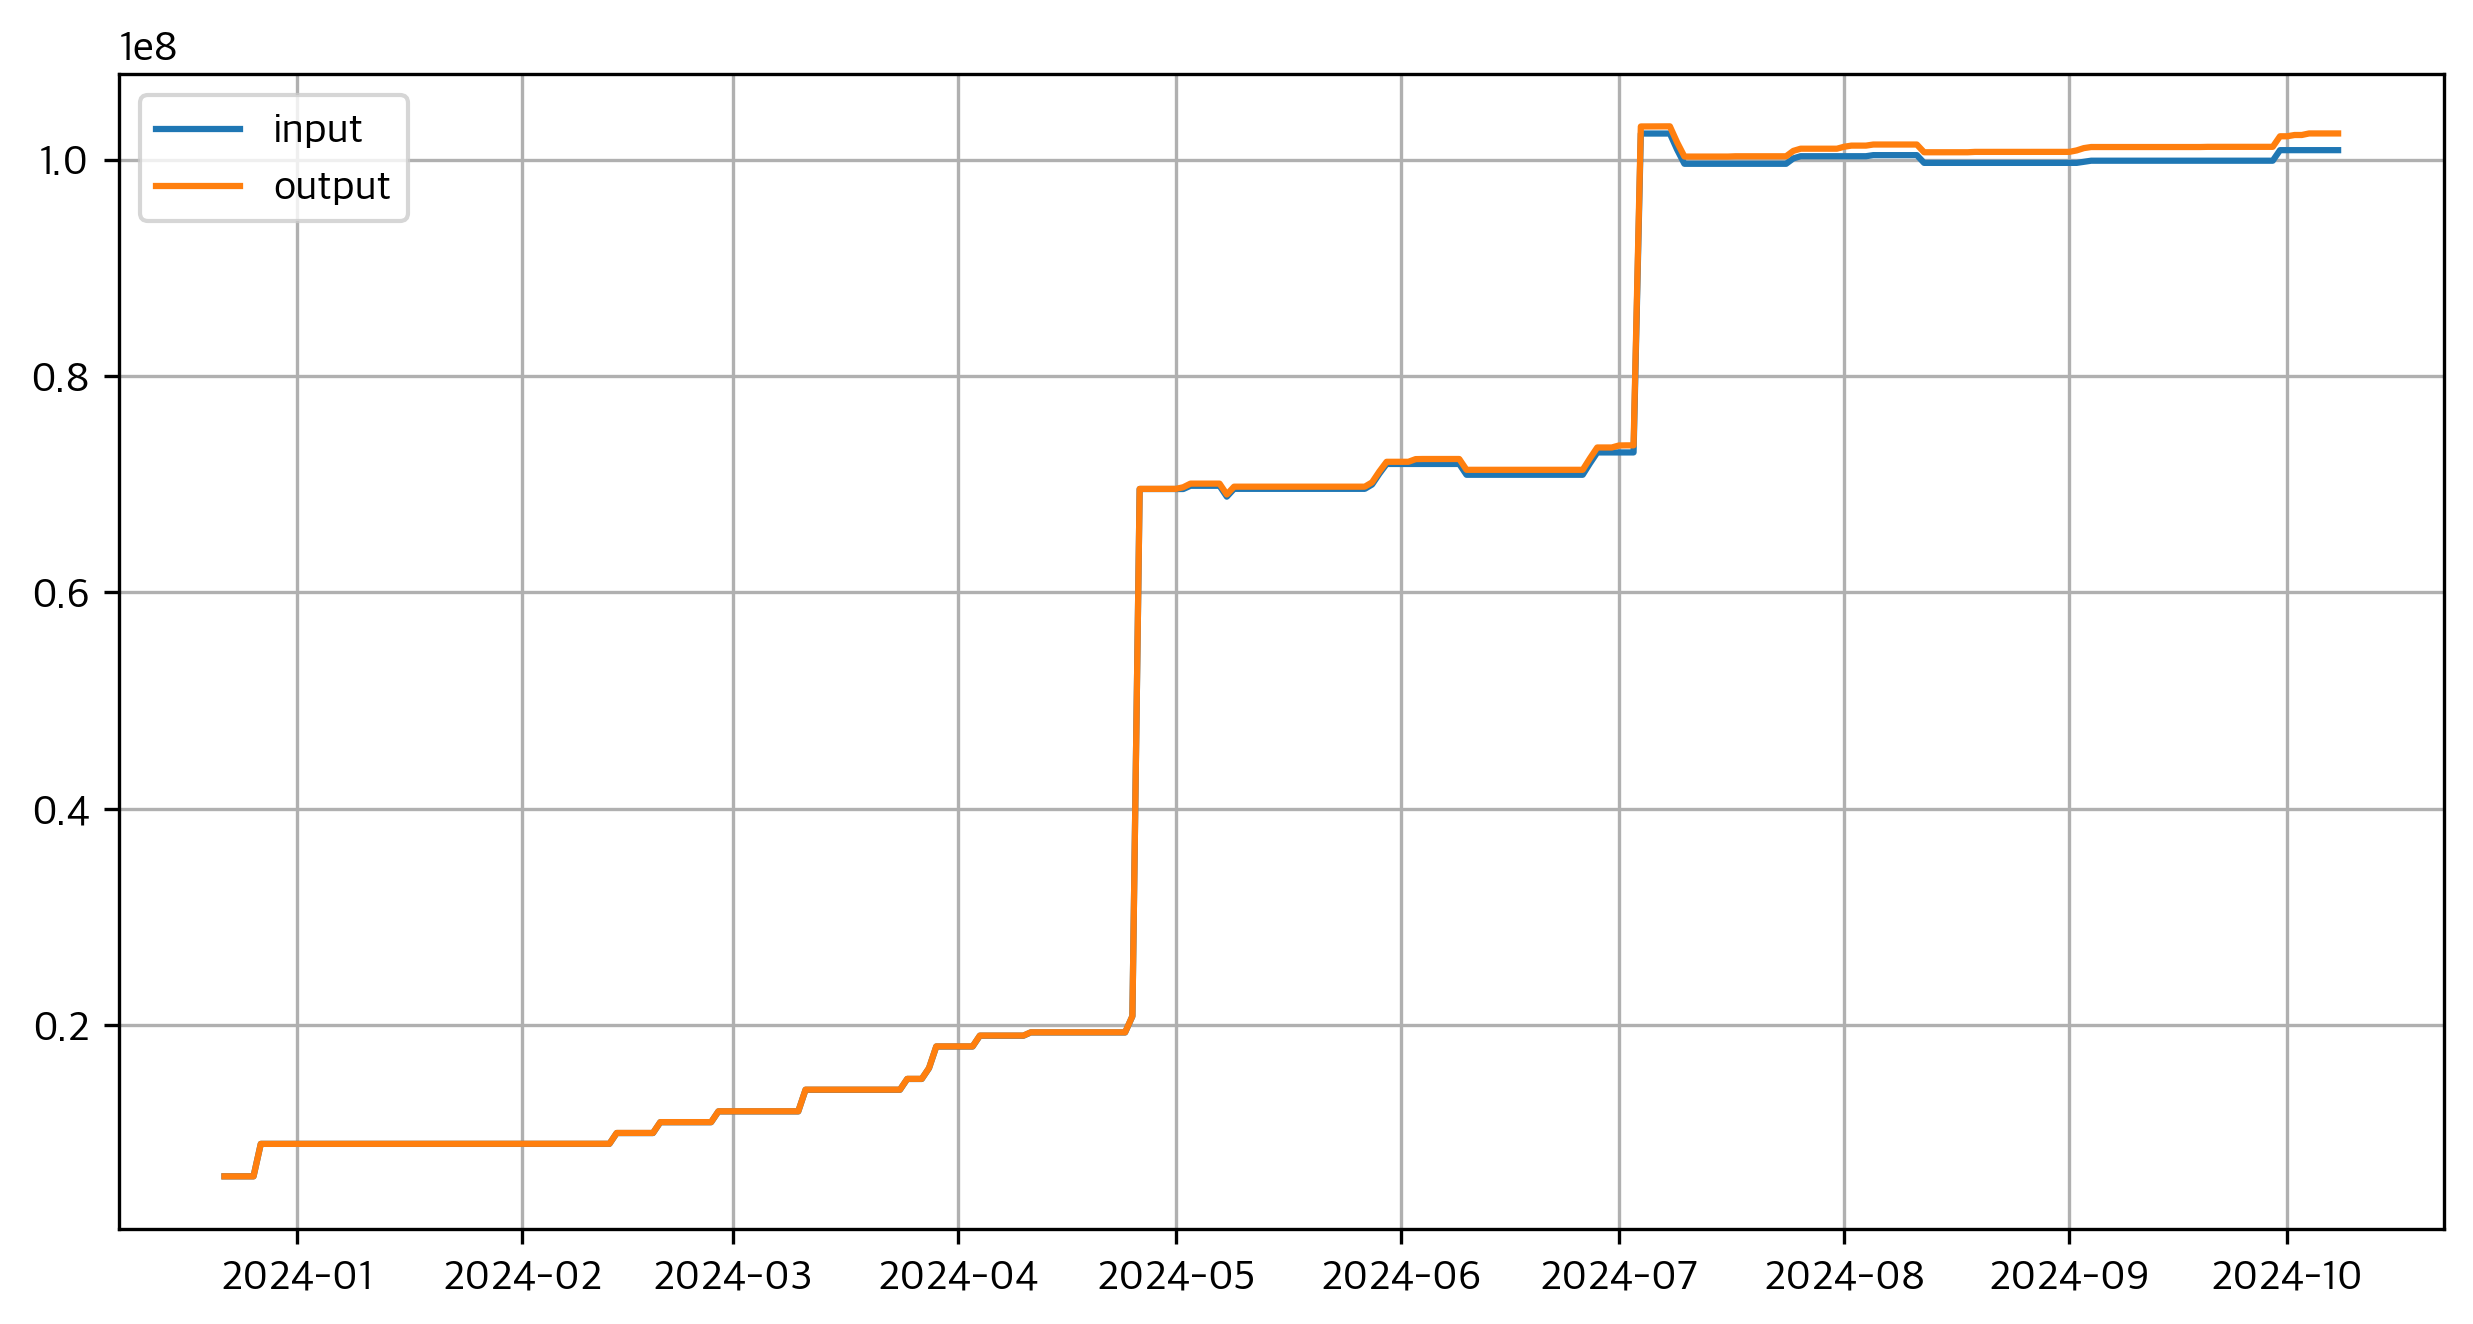

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(입출금['잔고1'], label='input')
plt.plot(입출금['잔고2'], label='output')
plt.grid(True)
plt.legend()


In [15]:
import pymysql
import keyring
import pandas as pd
from sqlalchemy import create_engine

password = keyring.get_password("mysql-rocketpig", "root")
user = 'root'
host = '220.76.60.248'
port = '3306'  # 기본적으로 MySQL은 3306 포트를 사용합니다
db = 'stock_db'

# SQLAlchemy 엔진 생성
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{db}?charset=utf8")

# 연결 테스트
with engine.connect() as connection:
    print("SQLAlchemy로 MySQL 연결 성공!")




SQLAlchemy로 MySQL 연결 성공!


In [16]:
입금.to_sql('deposit', engine, if_exists='replace')
출금.to_sql('withdraw', engine, if_exists='replace')
분배금.to_sql('distribution', engine, if_exists='replace')
이자.to_sql('interest', engine, if_exists='replace')

192